<a href="https://colab.research.google.com/github/hublun/Bayesian_Aggregation_Average_Data/blob/master/ODR_2024_1_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [ODE Based Models in Stan](https://mc-stan.org/events/stancon2017-notebooks/stancon2017-margossian-gillespie-ode.html)

#### [Example: simple harmonic oscillator](https://mc-stan.org/docs/stan-users-guide/example-simple-harmonic-oscillator.html#example-simple-harmonic-oscillator)

## [Bayesian workflow for disease transmission modeling in Stan](https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html)

#### [ Ordinary differential equation (ODE) solvers](https://mc-stan.org/docs/functions-reference/functions-ode-solver.html#functions-ode-solver)


In [1]:
install.packages("rstan", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘matrixStats’, ‘StanHeaders’, ‘inline’, ‘gridExtra’, ‘Rcpp’, ‘RcppParallel’, ‘loo’, ‘QuickJSR’, ‘RcppEigen’, ‘BH’




In [1]:
library(rstan)

Loading required package: StanHeaders


rstan version 2.32.5 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




In [4]:
parallel::detectCores()

[1] 8

In [5]:
#example(stan_model, package = "rstan", run.dontrun = TRUE)

In [6]:
#install.packages('tidybayes')

In [7]:
knitr::opts_chunk$set(echo = TRUE)
# color palette
c_light <- c("#fee0d2")
c_mid <- c("#fc9272")
c_dark <- c("#de2d26")
c_simu <- "chartreuse3"
c_posterior = "orange"
c_prior = "aquamarine2"

set.seed(1) # for reproductibility



---



## COVID-19 transmission in Switzerland

#### To illustrate the ideas presented in this tutorial, we are going to tackle a more complex example: COVID-19 transmission in Switzerland during the period from February 2020 to June 2020. We’ll see that in this more complicated setting, sampling from the posterior distribution can be difficult, and we’ll need to rely on Stan’s diagnostics to check that our inference is reliable.

In [8]:
library(tidybayes)
library(tidyverse)
library(gridExtra)
df_swiss <- read_csv("./disease_transmission_workflow/data/swiss_agg_data.csv")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.2.1     ✔ stringr 1.5.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Rows: 132 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (8): onset_dt, test_dt, report_dt, hospit_dt, death_dt, death_dt_hospit...
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
spec(df_swiss)

cols(
  date = col_date(format = ""),
  onset_dt = col_double(),
  test_dt = col_double(),
  report_dt = col_double(),
  hospit_dt = col_double(),
  death_dt = col_double(),
  death_dt_hospit = col_double(),
  death_dt_nohospit = col_double(),
  total_tested = col_double()
)

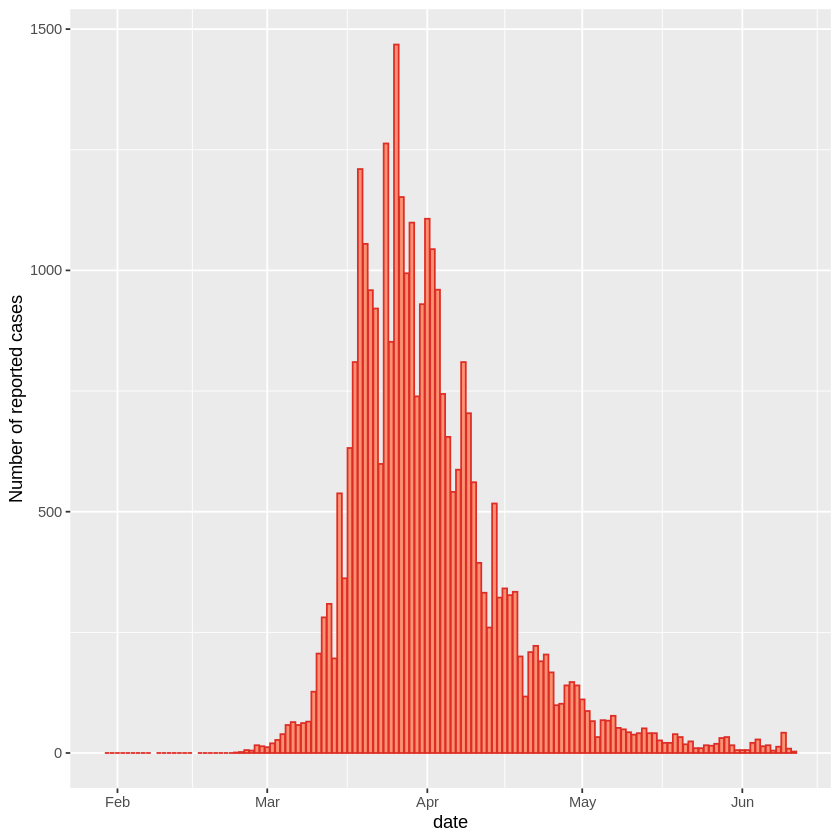

In [10]:
df_swiss %>% 
  ggplot() + 
  geom_bar(mapping = aes(x = date, y = report_dt), fill = c_mid, color = c_dark, stat = "identity") +
  labs(y="Number of reported cases")

### We are going to fit our basic model to the COVID-19 data, but we first need to make a few changes. In the influenza example, the number of students in bed was data on the disease prevalence, that is the number of students infected at time t. In this new setting, we only have access to the number of new cases on each given day, which constitutes incidence data. In a SIR model, the incidence of the disease at time t is the number of people leaving the Susceptible compartment at time t.

In [11]:
# Swiss population
N <- 8.57E6;

#initial conditions
i0 <- 1
s0 <- N - i0
r0 <- 0
y0 = c(S = s0, I = i0, R = r0)

### Improving the model
Our basic model doesn’t match our data. To make it fit, we can think of different improvements to the model to reflect the dynamics of disease:

* Due to the size of the COVID-19 epidemic and to limited testing capacities, there have been massive underreporting of cases. Our model could take this into account.

* Switzerland has put lock-down measures into place, and people have modified their behaviour in reaction to the virus: parameter β
 is not constant over time.

* We could account for the incubation time.

* We could account for the reporting time.

* We could make the initial number of infected people a parameter of the model.

* Given the growing literature on COVID-19, we could add information to our model. This can mean making our priors more informative, or adding different data.

We are going to incorporate several of these improvements into the model. We are going to do it one improvement at a time, to be able to understand where issues are coming from when it happens.

#### Incorporating underreporting
Let’s start with improvement 1, underreporting. We add a single parameter p_reported is the proportion of cases which get reported.

In [29]:
seir_model <- stan_model("./disease_transmission_workflow/stan_models/models_swiss/seir_ode_force.stan")

In [15]:
# Cases
cases <- df_swiss$report_dt

# times
n_days <- length(cases)
t <- seq(1, n_days, by = 1)
t0 = 0
ts <- t

data_seir <- list(n_days = n_days, t0 = t0, ts = ts, N = N, cases = cases)

In [36]:
fit_seir <- sampling(seir_model, 
                    data_seir, 
                    iter=1000,
                    seed = 0)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.01973 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 197.3 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 251.044 seconds (Warm-up)
Chain 1:                277.826 seconds (Sampling)
Chain 1:                528.87 sec

Warning message:
“There were 3 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.75, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”



Divergences:


3 of 2000 iterations ended with a divergence (0.15%).
Try increasing 'adapt_delta' to remove the divergences.




Tree depth:


0 of 2000 iterations saturated the maximum tree depth of 10.




Energy:


E-BFMI indicated no pathological behavior.



,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.430047641,0.814192217,1.250048236,0.272095842,0.288533354,0.766824049,2.498938212,3.931239443,2.357217,2.639543
gamma,0.145048182,0.052251882,0.122001794,0.028621219,0.067328188,0.076117907,0.207415027,0.468980969,5.451658,1.319199
phi,5.447478122,2.342692799,3.488229059,1.673080198,2.148207819,4.058963729,8.602683146,11.778578713,2.217069,3.127757
alpha,1.037369567,0.689401395,0.994722508,0.062781921,0.066158348,0.652018639,2.004406448,2.529455637,2.081899,4.958641
p_rep,0.005115365,0.001132867,0.001656405,0.003261823,0.003516982,0.004380805,0.006659715,0.007752061,2.137841,3.845641


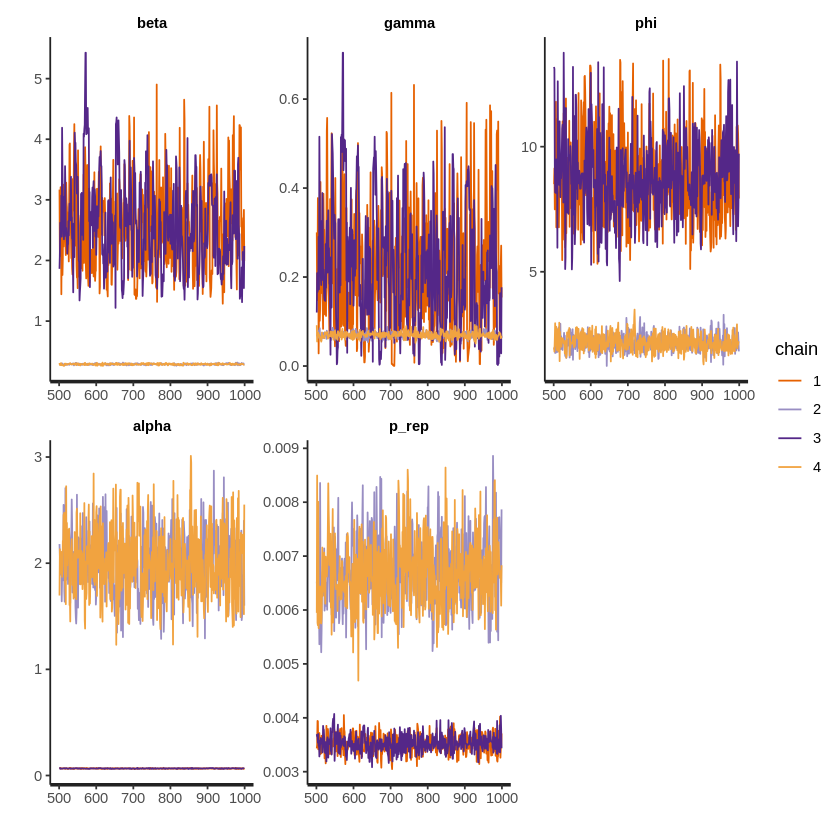

In [37]:
check_hmc_diagnostics(fit_seir)
pars = c("beta", "gamma", "phi", "alpha","p_rep")
summary(fit_seir, pars=pars)
traceplot(fit_seir, pars=pars)

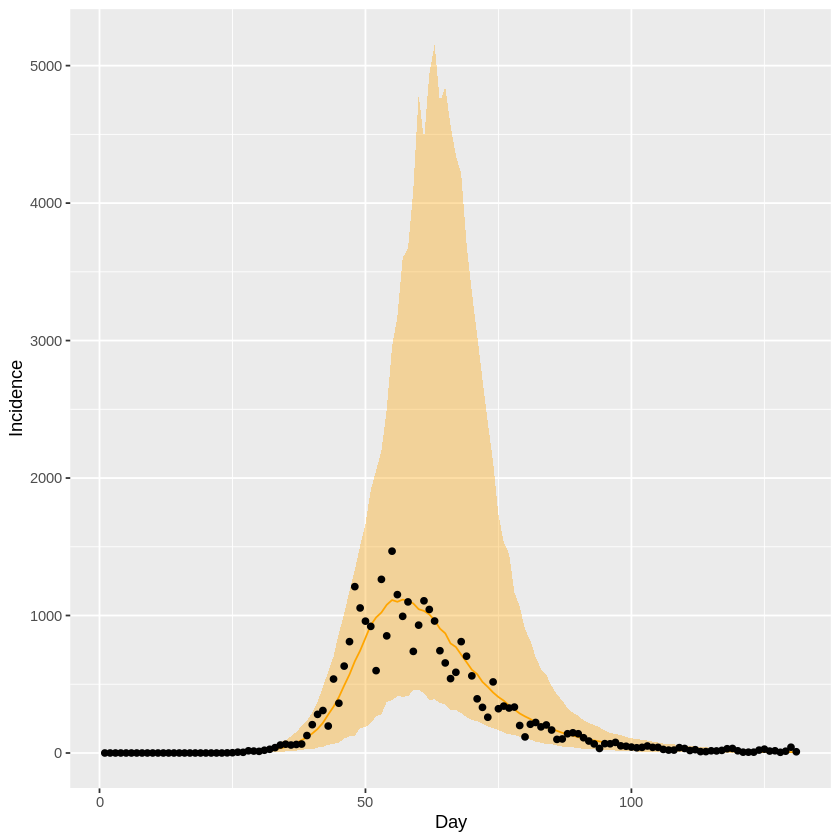

In [38]:
smr_pred <- cbind(as.data.frame(summary(fit_seir, pars = "pred_cases", probs = c(0.025, 0.05, 0.1, 0.5, 0.9, 0.95, 0.975))$summary), t=1:(n_days-1), cases = cases[1:length(cases)-1])
colnames(smr_pred) <- make.names(colnames(smr_pred)) # to remove % in the col names

ggplot(smr_pred, mapping = aes(x = t)) +
  #geom_ribbon(aes(ymin = X2.5., ymax = X97.5.), fill = c_dark, ) +
  geom_ribbon(aes(ymin = X5., ymax = X95.), fill = c_posterior, alpha=0.35) +
  #geom_ribbon(aes(ymin = X10., ymax = X90.), fill = c_light) +
  geom_line(mapping = aes(x = t, y = X50.), color = c_posterior) +
  geom_point(mapping = aes(y = cases)) +
  labs(x = "Day", y = "Incidence")

Joining with `by = join_by(n_days)`
`summarise()` has grouped output by 'n_days'. You can override using the
`.groups` argument.


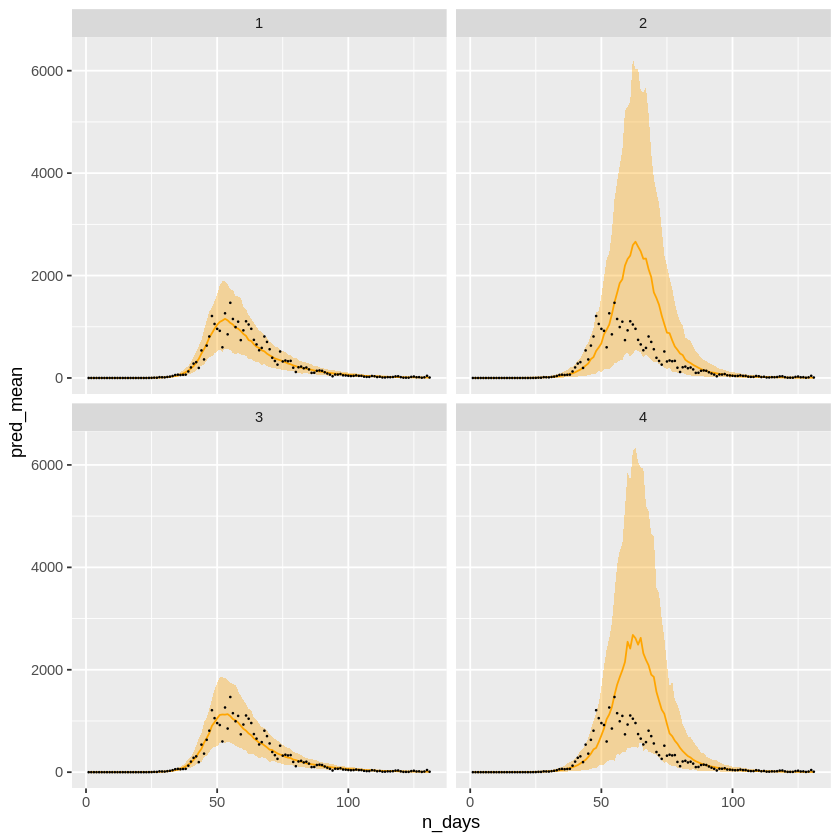

In [39]:
fit_seir %>% 
  spread_draws(pred_cases[n_days]) %>% 
  left_join(tibble(cases = cases, n_days = 1:length(cases))) %>% 
  group_by(n_days, .chain) %>% 
  summarise(cases = mean(cases), pred_mean = mean(pred_cases), pred_9 = quantile(pred_cases, 0.95), pred_1 = quantile(pred_cases, 0.05)) %>% 
   ggplot(aes(x = n_days)) +
   geom_ribbon(aes(ymin = pred_1, ymax = pred_9), fill = c_posterior, alpha=0.35)+
   geom_line(mapping = aes(y=pred_mean), color = c_posterior)+
   geom_point(mapping = aes(y=cases), size=0.1)+
  facet_wrap(~.chain)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


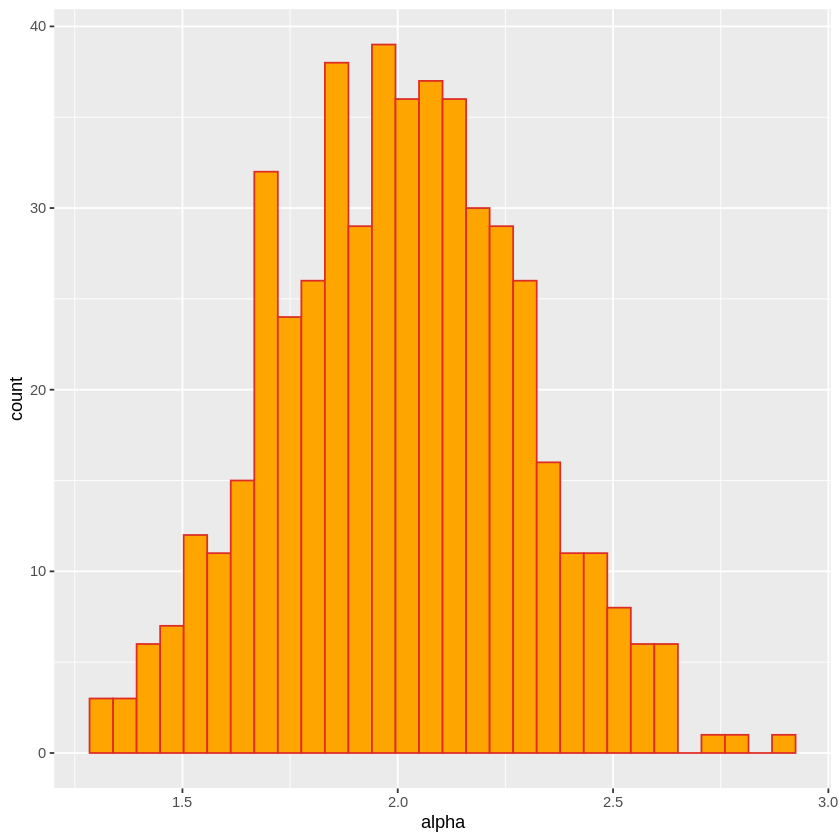

In [40]:
fit_seir %>% 
  spread_draws(alpha) %>% 
  filter(.chain == 2) %>% 
  ggplot() +
  geom_histogram(mapping = aes(x = alpha), fill=c_posterior, color=c_dark)

In [41]:
summary(fit_seir, pars = c("p_rep"))$c_summary

, , chains = chain:1

         stats
parameter        mean           sd        2.5%         25%         50%
    p_rep 0.003518166 0.0001664099 0.003186696 0.003411057 0.003516795
         stats
parameter         75%       97.5%
    p_rep 0.003627495 0.003828086

, , chains = chain:2

         stats
parameter        mean           sd        2.5%         25%         50%
    p_rep 0.006726884 0.0006270933 0.005565565 0.006332182 0.006692715
         stats
parameter         75%       97.5%
    p_rep 0.007155205 0.008167771

, , chains = chain:3

         stats
parameter        mean           sd        2.5%         25%         50%
    p_rep 0.003529649 0.0001636666 0.003240272 0.003419934 0.003516915
         stats
parameter         75%       97.5%
    p_rep 0.003632762 0.003881381

, , chains = chain:4

         stats
parameter       mean           sd        2.5%        25%         50%
    p_rep 0.00668676 0.0006255917 0.005639883 0.00626969 0.006630806
         stats
parameter         75%       97.5%
    p_rep 0.007078014 0.008102243

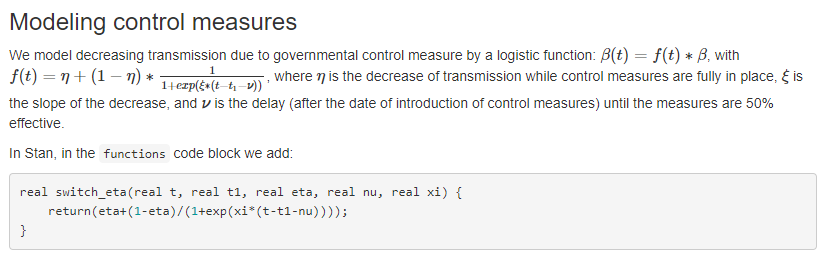